# Interactively validate a Convolutional Variational Autoencoder

The code in this nodebook is loading a pre-trained model and experiment with the encoder and decoder. 

In [1]:
import sys
sys.path.append("..")

from settings import Config
sys.path.append(Config().values["conv_vae"]["code_dir"])

# print(Config().values)

import argparse
import json
import re
import numpy as np
import torch
from tqdm import tqdm

# these imports are from the Conv-VAE package
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
from torch.nn import functional as F
import torchvision.utils as vutils
from torchvision import transforms
from torch.autograd import Variable
import os
import matplotlib.pyplot as plt
import argparse
import socket

from mpl_toolkits.axes_grid1 import ImageGrid
#Fixes PosixPath Error
import pathlib

# Oh, this hack was fixing something, but for me it is the other way around
#temp = pathlib.PosixPath
#pathlib.PosixPath = pathlib.WindowsPath

Proceeding to load config file: G:\My Drive\LotziStudy\Code\PackageTracking\VisionBasedRobotManipulator\settings\settings-LotziYoga.yaml


In [2]:
from conv_vae import get_config, create_configured_vae_json, latest_model, latest_training_run

In [4]:
model_path = pathlib.Path(Config().values["conv_vae"]["model_dir"])
model_path = pathlib.Path(model_path, "models", Config().values["conv_vae"]["model_name"])
latest = latest_training_run(model_path)
print(latest)
model_path = pathlib.Path(model_path, latest)
model = latest_model(model_path)

print(model_path)
# how to pick the latest file
print(model)  # Output: 87


0911_175514
c:\Users\lboloni\Documents\Code\_TempData\VisionBasedRobotManipulator-models\Conv-VAE\models\VAE_Robot\0911_175514
checkpoint-epoch3.pth


In [5]:
# As the code is highly dependent on the command line, emulating it here
args = argparse.ArgumentParser(description='PyTorch Template')
args.add_argument('-c', '--config', default=None, type=str,
                     help='config file path (default: None)')
args.add_argument('-r', '--resume', default=None, type=str,
                      help='path to latest checkpoint (default: None)')
args.add_argument('-d', '--device', default=None, type=str,
                      help='indices of GPUs to enable (default: all)')




_StoreAction(option_strings=['-d', '--device'], dest='device', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, required=False, help='indices of GPUs to enable (default: all)', metavar=None)

In [9]:

#model_path = pathlib.Path(VAE_MODEL_DIR, VAE_MODEL_FILE).resolve()
file = create_configured_vae_json()
# config = get_config(file)

resume_model = pathlib.Path(model_path, model)

# value = ["this-script", f"-c{file}", f"-r{model}"]
value = ["this-script", f"-c{file}", f"-r{resume_model}"]

# we are changing the parameters from here, to avoid changing the github 
# downloaded package
sys.argv = value
config = ConfigParser.from_args(args)
print(config)

c:\Users\lboloni\Documents\Code\_Checkouts\Robot\VisionBasedRobotManipulator\src\encoding_conv_vae\conv-vae-config-default.json
{'name': 'VAE_Robot', 'n_gpu': 1, 'arch': {'type': 'VanillaVAE', 'args': {'in_channels': 3, 'latent_dims': 128, 'flow': False}}, 'data_loader': {'type': 'CelebDataLoader', 'args': {'data_dir': 'c:\\Users\\lboloni\\Documents\\Code\\_TempData\\VisionBasedRobotManipulator-training-data\\vae-training-data', 'batch_size': 64, 'shuffle': True, 'validation_split': 0.2, 'num_workers': 2}}, 'optimizer': {'type': 'Adam', 'args': {'lr': 0.005, 'weight_decay': 0.0, 'amsgrad': True}}, 'loss': 'elbo_loss', 'metrics': [], 'lr_scheduler': {'type': 'StepLR', 'args': {'step_size': 50, 'gamma': 0.1}}, 'trainer': {'epochs': 3, 'save_dir': 'c:\\Users\\lboloni\\Documents\\Code\\_TempData\\VisionBasedRobotManipulator-models\\Conv-VAE\\', 'save_period': 1, 'verbosity': 2, 'monitor': 'min val_loss', 'early_stop': 10, 'tensorboard': True}}


In [10]:
logger = config.get_logger('test')

# setup data_loader instances
# LOTZI: this is a specific data loader, which with the current implementation, it is very specific to the celeba. It needs to be changed...

# FIXME: Initially I changed this data loader to something else and added into the data_loader a new one called RobotDataLoader. 
# But I should not change the github downloaded package. 
# So for the time being, I changed it back to CelebDataLoader, with the 
# awareness that I can specify something in config and update it correspondingly here 

data_loader = getattr(module_data, config['data_loader']['type'])(
    config['data_loader']['args']['data_dir'],
    batch_size=36,
    shuffle=False,
    validation_split=0.0,
    # training=False,
    num_workers=2
)

# LOTZI: this is an uninitialized model architecture
# build model architecture
model = config.init_obj('arch', module_arch)
logger.info(model)

# get function handles of loss and metrics
loss_fn = getattr(module_loss, config['loss'])
# metric_fns = [getattr(module_metric, met) for met in config['metrics']]



INFO:test:VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
 

In [11]:
# logger.info('Loading checkpoint: {} ...'.format(config.resume))
# checkpoint = torch.load(config.resume)

# loading on CPU-only machine
print("Loading the checkpoint")
checkpoint = torch.load(config.resume, map_location=torch.device('cpu'))
print("Checkpoint loaded")

state_dict = checkpoint['state_dict']
if config['n_gpu'] > 1:
    model = torch.nn.DataParallel(model)
model.load_state_dict(state_dict)

# prepare model for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()


Loading the checkpoint
Checkpoint loaded


C:\Users\lboloni\AppData\Local\Temp\ipykernel_7012\2087784403.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config.resume, map_location=torch.d

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Se

In [12]:
print(model)
print(model.encoder)
print(f"latent_dim {model.latent_dim}")
# print(model.hidden_dims)

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Se

## Pass one picture through the complete autoencoder

Pass one specific picture through the complete autoencoder. Compare the input and the output. This is basically trying out whether the VAE had captured the picture sufficiently.

This code also is intended as a sample of how to use the pre-trained model, how to feed it new data without the training code. 

In [14]:
from PIL import Image
import torchvision.transforms as transforms


# picture_name = '../../localdata/img/Rafael.jpg'
# picture_name = '../../localdata/img/indian-man.jpeg'
# picture_name = '../../localdata/img/00029_dev2.jpg'

# This is just a randomly chosen image from the training data. 

directory = pathlib.Path(Config().values["conv_vae"]["training_data_dir"], "Class-Folder")

files = list(directory.glob('*.jpg'))
picture_name = pathlib.Path(directory, files[11])


L
torch.Size([3, 64, 64])


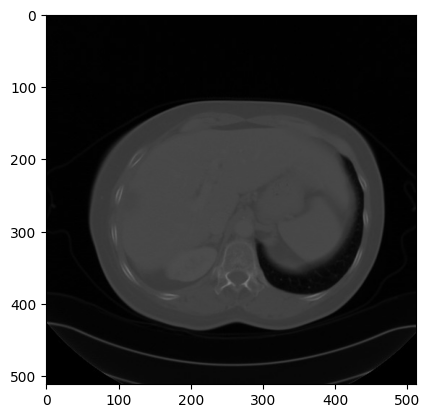

In [15]:


#"ID_0046_AGE_0072_CONTRAST_1_CT.jpg")
# Load an image using PIL
image = Image.open(picture_name)

plt.imshow(image)

print(image.mode)
# at least for the medical image, this is in 16 bit unsigned integer
# 
image = image.convert("RGB")

plt.imshow(image)

# Define a transform pipeline (e.g., converting to tensor)
# transform = transforms.ToTensor()
image_size = 64

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
])


# Apply the transform
image_tensor = transform(image)

# Display some information about the image tensor
print(image_tensor.shape)  # e.g., torch.Size([3, H, W])

# Convert the tensor to a format suitable for matplotlib (from [C, H, W] to [H, W, C])
image_tensor_for_pic = image_tensor.permute(1, 2, 0)
#plt.imshow(image_tensor_for_pic)


mu = tensor([[ 0.6547, -0.9024, -1.4493,  0.8639,  0.8873, -0.2609, -0.3873, -0.3974,
          0.4640,  0.1115,  0.6745, -0.6475, -0.9846,  0.7020, -0.9154, -0.5401,
          0.9313, -1.0929,  0.9619,  1.0673,  0.8053,  0.2453, -0.6255,  0.9272,
          0.6157, -0.9469, -0.5537, -0.6101,  0.0399, -0.9358, -0.2049, -0.9946,
          0.4518, -1.0096, -0.8009, -0.5459,  0.7094, -0.9994, -0.8558,  1.0069,
         -0.2002, -0.1550,  1.0378,  0.6690,  0.5931,  0.6263,  0.8616, -0.3997,
         -1.0277,  0.7085, -0.1718, -0.4567,  0.9152, -0.1902,  0.8017,  0.9889,
         -0.0923,  0.2035,  0.2436, -0.8884,  0.3407,  0.8442,  0.1808, -0.7284,
         -1.0394, -0.5394,  0.9157,  0.4221,  0.5127, -0.6429,  0.2549, -0.4370,
         -0.4672, -0.2596, -0.8512,  0.5546,  1.0675, -0.1698,  0.6919, -0.7189,
         -0.9454, -1.0422, -1.0305,  0.0566, -0.7927, -0.8324,  0.2096, -0.1431,
          0.8763, -0.8073, -0.4442, -0.3232, -0.6116, -1.0489,  0.6885,  0.6389,
          0.9270, -1.00

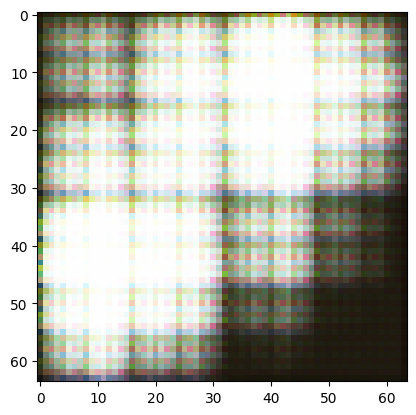

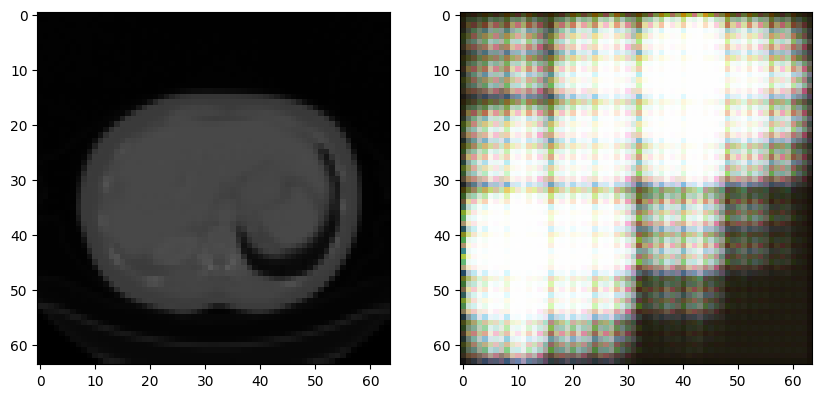

In [16]:

# Add a batch dimension: shape becomes [1, 3, 224, 224]
image_tensor_2 = image_tensor.unsqueeze(0)

# Move tensor to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor_3 = image_tensor_2.to(device)

# Running the input on the output
output, mu, logvar = model(image_tensor_3)

# Output: the visual reconstruction
#print(output)
output_for_pic = output[0].cpu().permute(1, 2, 0).detach().numpy()
plt.imshow(output_for_pic)

# mu: the encoding, I think
print(f"mu = {mu}")

# log_var: the log-var values for this input 
print(f"logvar = {logvar}")

# initial and new
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_tensor_for_pic)
axs[1].imshow(output_for_pic)


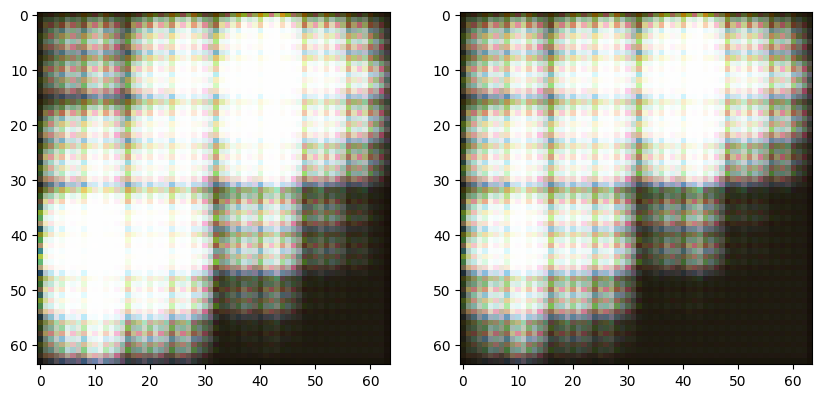

In [20]:

# Try to do a decoding from the same mu
z2 = model.reparameterize(mu, logvar)

for i in range(Config().values["robot"]["latent_encoding_size"]):
    z2[0][i] = z2[0][i] + 0.1

#z2[0][1] = 2.0
#z2[0][3] = 2.0
output2 = model.decode(z2)
output_for_pic2 = output2[0].cpu().permute(1, 2, 0).detach().numpy()

# initial and new
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(output_for_pic)
axs[1].imshow(output_for_pic2)


# Generating random samples from

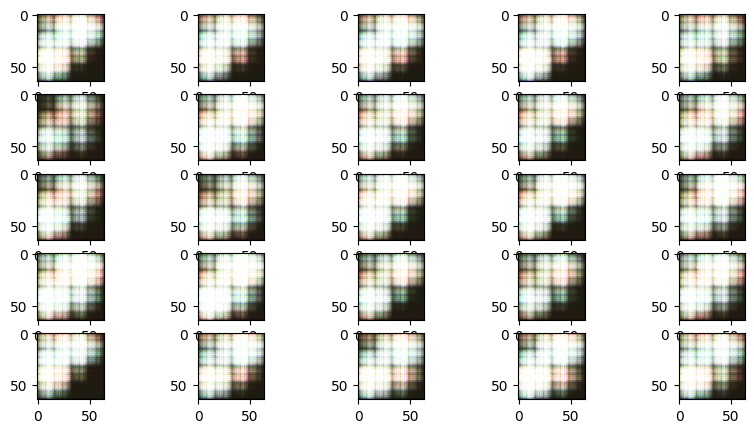

In [24]:
import random

# z2 = model.reparameterize(mu, logvar)
# initial and new
fig, axs = plt.subplots(5, 5, figsize=(10, 5))
for x in range(0, 5):
    for y in range(0, 5):
            z2 = model.reparameterize(mu, logvar)
            for i in range(Config().values["robot"]["latent_encoding_size"]):
                z2[0][i] += random.uniform(-0.5, 0.5)
            output2 = model.decode(z2)
            output_for_pic2 = output2[0].cpu().permute(1, 2, 0).detach().numpy()
            axs[x][y].imshow(output_for_pic2)
#axs[0].imshow(output_for_pic)
#axs[1].imshow(output_for_pic2)